# Table of contents
1. [Introduction: Business Problem](#introduction)
2. [Data Gathering](#Data_Gathering)
3. [Problem Solving Methodology](#Methodology)
4. [Analysis & Results](#Analysis_Results)
    1. [Analysis](#Analysis)
    2. [Results](#Results)
5. [Discussion](#Discussion)
6. [Conclusion](#Conclusion)


## 1. Introduction: Business Problem  <a name="introduction"></a>

This project deals with discussing the neighborhoods of Chennai, Tamilnadu in India. This project would specifically help Business community planning to start Restaurants, Hotels, Café etc. in Chennai

The Foursquare API is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analyzing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the k-means clustering algorithm is used to achieve the task. The optimal number of clusters can be obtained using silhouette score. Folium visualization library can be used to visualize the clusters superimposed on the map of Chennai city. 
These clusters will be further analyzed to help business owners selecting a potential location to open-up Hotels, Shopping Malls, Restaurants or Coffee shops.


### Importing the required libraries

In [1]:
import numpy as np
import re
import json
import requests
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


## 2. Data Gathering <a name="Data_Gathering"></a>

Chennai has multiple potential neighborhoods. Let’s use the following dataset with data wrangling and beautification techniques to produce meaningful information.

##### Loading Data from various sources
 Chennai Neighborhood data with their Latitude and Longitude from below path and then converting html data into a data frame (table). \
 https://chennaiiq.com/chennai/latitude_longitude_areas.asp
 
 
But the Latitude and Longitude data provided here is in Degrees Minute Seconds format. Thus before starting the analysis, the location data has to be converted to Decimal Degrees. Let's First, review the the html file.

In [2]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of **200** shows that the process was successful. Now we need to clean the file to access the Neighborhoods and their Locations. Lets use BeautifulSoup library to parse the html file in order to make it easier to access.

In [3]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})


The html has been parsed and it can be used to build the dataset. Let us access the Location data and store it in a pandas dataframe, chennai_data.

##### Data Wrangling

In [4]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"


##### Convert Degrees Minute Seconds to Decimal Degrees

The **dms2dd** fucntion defined below will solve this problem.

In [5]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Chennai. The latitude and longitude of chennai can be obtained using the Geolocator library.

In [6]:

address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


#### The Chennai Map:

In [7]:
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=12
                         
                        )    
chennai_map

##### Chennai Map with the neighborhoods markers in blue

In [8]:
# add neighborhood markers to map
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

##### Define Foursquare Credentials and Version and will hide this sensitive information

In [12]:
CLIENT_ID = 'GK0HSEQ4HTDP0SOWAE0OGEMIBZUD4FI5EK2GGGASEKOQ2EHB' # your Foursquare ID
CLIENT_SECRET = 'WRQF3LNLDLS4O2LVFWASNVIKZMYSJLAMWIJJJDIFLMOPSPIP' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GK0HSEQ4HTDP0SOWAE0OGEMIBZUD4FI5EK2GGGASEKOQ2EHB
CLIENT_SECRET:WRQF3LNLDLS4O2LVFWASNVIKZMYSJLAMWIJJJDIFLMOPSPIP


##### Explore neighborhoods in Chennai

The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters or 1/2 KM.

In [13]:

def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets use the above function on the chennai_data neighborhoods dataframe and store the venues data returned in the chennai_venues pandas dataframe.

In [14]:

chennai_venues = getNearbyVenues(names = chennai_data['Neighborhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1178, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Debot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant


A total of **1167** venues were obtained. Now lets check the number of venues returned per neighborhood.

In [15]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,4,4,4,4,4,4
Adyar Bus Debot,15,15,15,15,15,15
Adyar Signal,32,32,32,32,32,32
Alandur,10,10,10,10,10,10
Ambattur,1,1,1,1,1,1
Anna Arch,11,11,11,11,11,11
Anna Nagar Roundana,20,20,20,20,20,20
Anna Nagar West Terminus,8,8,8,8,8,8
Anna Statue,13,13,13,13,13,13


From the above dataframe we can see that **Taj Coromandal** returned the highest number of venues i.e. 51. Now lets check the unique categories of all the venues returned.

In [16]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 156 uniques categories.


## 3. Problem Solving Methodology <a name="Methodology"></a>

Now, we have the neighborhoods data of chennai (i.e. total 105 neighborhoods). We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of ***1167 venues*** have been obtained in the whole city and ***148 unique categories***. But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the neighborhoods with more than 10 venues.

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset.\
K - Nearest Neighbor clustering technique have been used and to find the optimal number of clusters silhouette score metric technique is used.
The clusters obtained can be analyzed to find the major type of venue categories in each cluster. The outcome then can be used to suggest business people, potential locations based on the category.

## 4. Analysis & Results <a name="Analysis_Results"></a>

### 4.1 Analysis  <a name="Analysis"></a>

Lets visualize the number of venues obtained in all the neighborhoods of Chennai.

<AxesSubplot:xlabel='Neighborhood'>

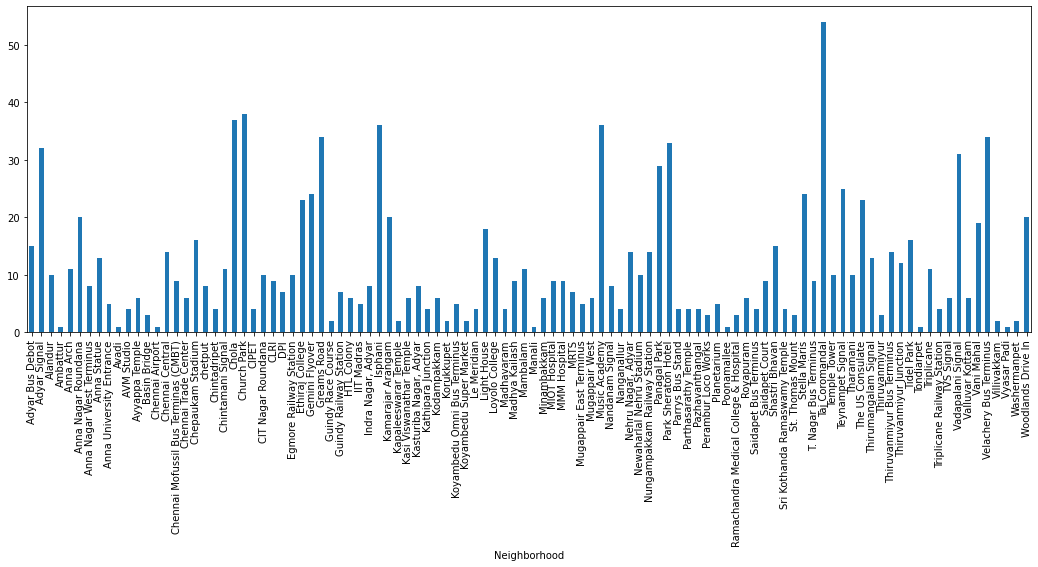

In [17]:
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As we can see from the above bar chart, there are many neighborhoods with less than 10 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 10 or more than 10 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

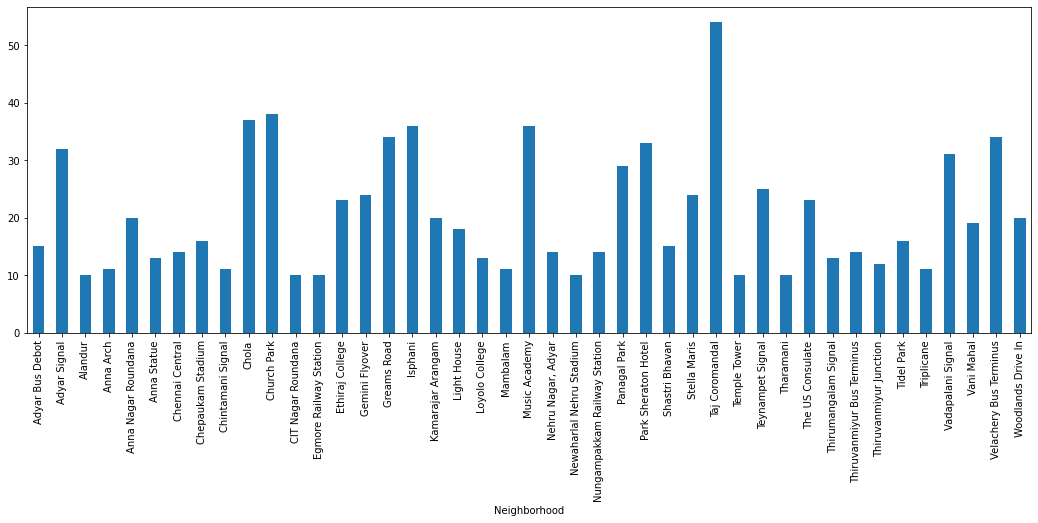

In [18]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, chennai_venues_top that contains only the neighborhoods with 10+ venues and the venues with their details included.

In [19]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Debot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant


#### ***One-Hot Incoding***

In [20]:

chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(883, 125)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Line,Bus Station,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Court,Food Truck,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Health & Beauty Service,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Playground,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [21]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(43, 125)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Line,Bus Station,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food Court,Food Truck,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Health & Beauty Service,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Playground,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Sports Bar,Steakhouse,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.133333,0.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.133333,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00,0.00000,0.2000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.00,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.066667,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,Adyar Signal,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.031250,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.000000,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.03125,0.0,0.0,0.062500,0.0,0.031250,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.00,0.03125,0.3125,0.0,0.0,0.03125,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.03125,0.0,0.000000,0.0,0.0,0.0,0.0625,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.03125,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0
2,Alandur,0.0,0.0,0.1,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.1,0.1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.1,0.10,0.00000,0.2000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.1,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,Anna Arch,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.181818,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.181818,0.0,0.181818,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00

The following function returns the **top_venues** of each neighborhood.

In [22]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe *neighborhoods_venues_sorted*.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Middle Eastern Restaurant,Pizza Place,Fruit & Vegetable Store,Café,BBQ Joint
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Electronics Store,Coffee Shop,Rock Club,Snack Place,Lounge,Café,Bookstore,Juice Bar
2,Alandur,Indian Restaurant,South Indian Restaurant,Hotel,Metro Station,Bus Station,Bus Line,Bar,Hotel Bar,Airport,Arts & Crafts Store
3,Anna Arch,Clothing Store,Electronics Store,Fast Food Restaurant,Shopping Mall,Pizza Place,Bookstore,Café,Multiplex,Diner,Donut Shop
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Middle Eastern Restaurant,Electronics Store,Paper / Office Supplies Store,Clothing Store



Cluster Neighborhoods
Here k-Nearest Neighborhoods clustering technique is used. I will  use the **silhouette_score** to obtain the best value for the number of clusters.

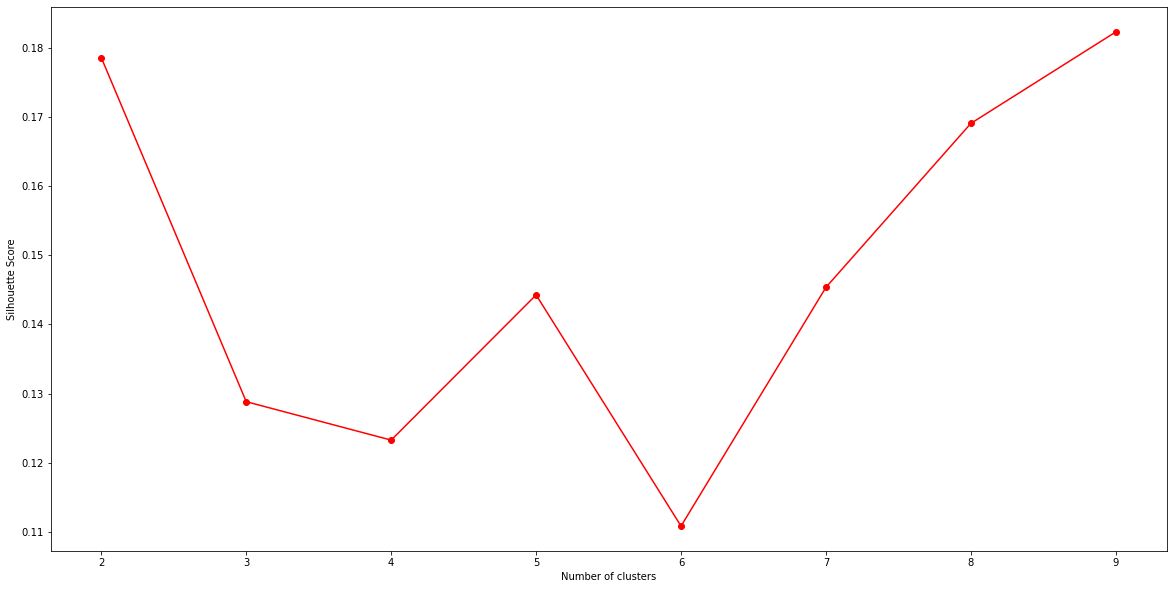

In [24]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the **highest silhouette score is 9**. So, lets consider the number of clusters as 8.

In [25]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

# Use silhouette score to find optimal number of clusters to segment the data
kclusters = np.arange(2,10)
results = {}
for size in kclusters:
    model = KMeans(n_clusters = size).fit(chennai_grouped_clustering)
    predictions = model.predict(chennai_grouped_clustering)
    results[size] = silhouette_score(chennai_grouped_clustering, predictions)

best_size = max(results, key=results.get)
best_size

6

In [26]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 0, 8, 3, 4, 2, 6, 3, 3], dtype=int32)

Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new datframe chennai_merged which has the neighborhood details, **cluster labels** and the 10 most common venues in that neighborhood.

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head(1000)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.997222,80.256944,3,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Middle Eastern Restaurant,Pizza Place,Fruit & Vegetable Store,Café,BBQ Joint
1,Adyar Signal,13.006389,80.257500,3,Indian Restaurant,North Indian Restaurant,Electronics Store,Coffee Shop,Rock Club,Snack Place,Lounge,Café,Bookstore,Juice Bar
2,Alandur,13.007778,80.209722,0,Indian Restaurant,South Indian Restaurant,Hotel,Metro Station,Bus Station,Bus Line,Bar,Hotel Bar,Airport,Arts & Crafts Store
3,Anna Arch,13.074444,80.218333,8,Clothing Store,Electronics Store,Fast Food Restaurant,Shopping Mall,Pizza Place,Bookstore,Café,Multiplex,Diner,Donut Shop
4,Anna Nagar Roundana,13.084444,80.218056,3,Indian Restaurant,Chinese Restaurant,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Middle Eastern Restaurant,Electronics Store,Paper / Office Supplies Store,Clothing Store
5,Anna Statue,13.068056,80.271944,4,Indian Restaurant,Multiplex,Flea Market,Dessert Shop,General Entertainment,Movie Theater,Electronics Store,Convenience Store,Cosmetics Shop,Coworking Space
6,Chennai Central,13.082222,80.275556,6,Indian Restaurant,Train Station,Bookstore,Nightclub,Hotel,Platform,Bus Station,Metro Station,Sandwich Place,Fast Food Restaurant
7,Chepaukam Stadium,13.064167,80.266389,3,Indian Restaurant,Electronics Store,Café,Breakfast Spot,Mediterranean Restaurant,Bar,Cafeteria,General Entertainment,Multiplex,Hotel
8,Chintamani Signal,13.085000,80.224167,3,Indian Restaurant,Restaurant,Chinese Restaurant,Bakery,Middle Eastern Restaurant,Ice Cream Shop,Coffee Shop,Coworking Space,Cosmetics Shop,Dance Studio
9,Chola,13.044167,80.259722,0,Indian Restaurant,Hotel,Ice Cream Shop,Concert Hall,Electronics Store,Café,Chinese Restaurant,Gym,Comfort Food Restaurant,Dessert Shop


We will check  randomly some dataset shape.

In [28]:
chennai_merged1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[3, 4] + list(range(5, chennai_merged.shape[1]))]]
chennai_merged1.shape

(19, 11)

In [29]:
chennai_merged2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[3, 4] + list(range(5, chennai_merged.shape[1]))]]
chennai_merged2.shape

(3, 11)

We can also visualie the density of Neighborhood by cluster label in a chart below.

<AxesSubplot:ylabel='Cluster Labels'>

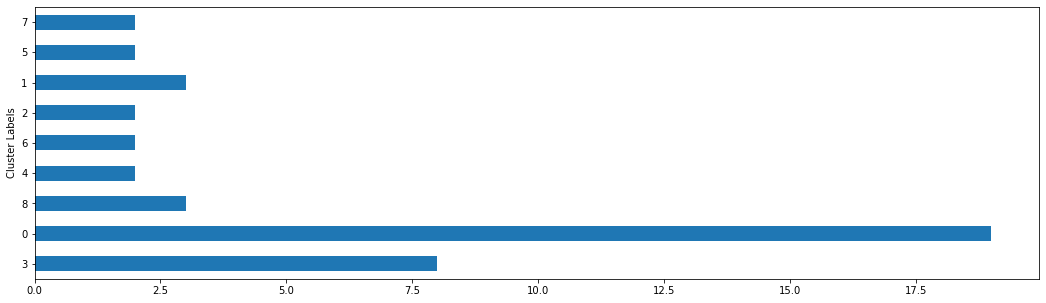

In [30]:
df = chennai_merged.groupby(['Cluster Labels'], sort=False)['Neighborhood'].count()
df.plot.barh(figsize=(18,5))

As we can see in above datframe **Cluster 0** Contains the highest cluster density. We need to find the geographic centroid for this cluster. This is the most suitable  location for a new business set-up

In [31]:
Cluster_0_coorid = chennai_merged[['Neighborhood Latitude', 'Neighborhood Longitude']]
Cluster_0_coorid = list(Cluster_0_coorid.values) 
lat = []
long = []



for l in Cluster_0_coorid:
  lat.append(l[0])
  long.append(l[1])



Blatitude = sum(lat)/len(lat)
Blongitude = sum(long)/len(long)
print(Blatitude)
print(Blongitude)

13.043682170542633
80.24649870801032


***Install opencage to reverse lookup the coordinates***

In [33]:

#Obtain the popupstring of the best location
popstring = chennai_data[chennai_data['Neighborhood'].str.contains('Teynam')]

def str_join(*args):
    return ''.join(map(str, args))

popstring_new = str_join('The Best suitable Neighbourhood to locate a New Business is in: ', popstring['Neighborhood'].values)


print(popstring_new)

The Best suitable Neighbourhood to locate a New Business is in: ['Teynampet Signal']


In [35]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="Project 3A99B5")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


### 4.2 Results  <a name="Results"></a>

We need to dig more to find out compilmentary business set-ups in each clusters in oreder to suggest a most suitable custer for new bsuiness set-up. So Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

#### Cluster 1

In [36]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Alandur,Indian Restaurant,South Indian Restaurant,Hotel,Metro Station,Bus Station,Bus Line,Bar,Hotel Bar,Airport,Arts & Crafts Store
9,Chola,Indian Restaurant,Hotel,Ice Cream Shop,Concert Hall,Electronics Store,Café,Chinese Restaurant,Gym,Comfort Food Restaurant,Dessert Shop
10,Church Park,Indian Restaurant,Multiplex,Bakery,Juice Bar,Movie Theater,Café,Chinese Restaurant,Middle Eastern Restaurant,Bar,Pub
12,Egmore Railway Station,Vegetarian / Vegan Restaurant,Pizza Place,Indian Restaurant,Café,Farmers Market,Movie Theater,Hotel,Train Station,Arcade,Food Court
13,Ethiraj College,Hotel,Café,Juice Bar,Kebab Restaurant,Pizza Place,Indian Restaurant,Restaurant,Coffee Shop,Fast Food Restaurant,Mexican Restaurant
14,Gemini Flyover,Indian Restaurant,Sandwich Place,Coffee Shop,Nightclub,Hotel,Chinese Restaurant,Bar,Department Store,Park,Café
15,Greams Road,Multiplex,Café,Indian Restaurant,Middle Eastern Restaurant,Bakery,Movie Theater,Juice Bar,Kebab Restaurant,Clothing Store,Restaurant
16,Isphani,Indian Restaurant,Hotel,Chinese Restaurant,Nightclub,Sandwich Place,Coffee Shop,Lounge,Pizza Place,South Indian Restaurant,Café
17,Kamarajar Arangam,Café,Indian Restaurant,Lounge,Nightclub,Hotel,BBQ Joint,Ice Cream Shop,Coworking Space,Concert Hall,Coffee Shop
21,Music Academy,Indian Restaurant,Hotel,Café,Concert Hall,Fruit & Vegetable Store,Lounge,Juice Bar,Italian Restaurant,Ice Cream Shop,Gym


In [37]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Indian Restaurant     19
Hotel                 16
Café                  13
Chinese Restaurant    10
Coffee Shop            8
Lounge                 6
Department Store       6
Nightclub              6
Sandwich Place         6
Pizza Place            5
dtype: int64


#### Cluster 2

In [38]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Light House,Fast Food Restaurant,Coffee Shop,Juice Bar,Multiplex,Department Store,Food Court,Beach,Bar,Sculpture Garden,Shopping Mall
19,Loyolo College,Women's Store,Bakery,Vegetarian / Vegan Restaurant,Gourmet Shop,Fast Food Restaurant,Mexican Restaurant,Department Store,Clothing Store,Chinese Restaurant,Café
24,Nungampakkam Railway Station,Train Station,Department Store,Women's Store,Clothing Store,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,South Indian Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant


In [39]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Fast Food Restaurant             3
Department Store                 3
Clothing Store                   2
Vegetarian / Vegan Restaurant    2
Women's Store                    2
Chinese Restaurant               2
Bar                              1
Coffee Shop                      1
South Indian Restaurant          1
Café                             1
dtype: int64


#### Cluster 3

In [40]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,CIT Nagar Roundana,Cocktail Bar,South Indian Restaurant,Italian Restaurant,Metro Station,Department Store,Hotel,Pub,Bar,Ice Cream Shop,Art Gallery
30,Temple Tower,South Indian Restaurant,Art Gallery,Bar,Pub,Department Store,Playground,Sports Bar,Metro Station,Hotel,Cocktail Bar


In [41]:

cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Department Store           2
Metro Station              2
Pub                        2
Cocktail Bar               2
Art Gallery                2
South Indian Restaurant    2
Hotel                      2
Bar                        2
Ice Cream Shop             1
Sports Bar                 1
dtype: int64


#### Cluster 4

In [42]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Middle Eastern Restaurant,Pizza Place,Fruit & Vegetable Store,Café,BBQ Joint
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Electronics Store,Coffee Shop,Rock Club,Snack Place,Lounge,Café,Bookstore,Juice Bar
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Bookstore,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Middle Eastern Restaurant,Electronics Store,Paper / Office Supplies Store,Clothing Store
7,Chepaukam Stadium,Indian Restaurant,Electronics Store,Café,Breakfast Spot,Mediterranean Restaurant,Bar,Cafeteria,General Entertainment,Multiplex,Hotel
8,Chintamani Signal,Indian Restaurant,Restaurant,Chinese Restaurant,Bakery,Middle Eastern Restaurant,Ice Cream Shop,Coffee Shop,Coworking Space,Cosmetics Shop,Dance Studio
27,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Asian Restaurant,Japanese Restaurant,Multicuisine Indian Restaurant,Convenience Store,Coffee Shop,Hotel,Theater,Art Gallery
34,Thirumangalam Signal,Indian Restaurant,Jewelry Store,Pizza Place,Café,Department Store,Print Shop,Mobile Phone Shop,Metro Station,Smoke Shop,Market
41,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Restaurant,Vegetarian / Vegan Restaurant,Pizza Place,Multiplex,Men's Store,Liquor Store


In [43]:

cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Indian Restaurant                8
Café                             4
Chinese Restaurant               4
Fast Food Restaurant             3
Coffee Shop                      3
Middle Eastern Restaurant        3
Pizza Place                      3
Electronics Store                3
Breakfast Spot                   2
Vegetarian / Vegan Restaurant    2
dtype: int64


#### Cluster 6

In [44]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Anna Statue,Indian Restaurant,Multiplex,Flea Market,Dessert Shop,General Entertainment,Movie Theater,Electronics Store,Convenience Store,Cosmetics Shop,Coworking Space
38,Triplicane,Indian Restaurant,Multiplex,General Entertainment,Dessert Shop,Electronics Store,Flea Market,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space


In [45]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Electronics Store        2
Convenience Store        2
Flea Market              2
Cosmetics Shop           2
Coworking Space          2
General Entertainment    2
Multiplex                2
Dessert Shop             2
Indian Restaurant        2
Concert Hall             1
dtype: int64


#### Cluster 6

In [46]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Tharamani,Food Court,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Office,Café,Cafeteria,Sandwich Place,Vegetarian / Vegan Restaurant,Arts & Crafts Store
37,Tidel Park,Food Court,Café,Sandwich Place,Office,Indian Restaurant,Juice Bar,Platform,Bus Station,Fast Food Restaurant,Vegetarian / Vegan Restaurant


In [47]:

cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Fast Food Restaurant             2
Office                           2
Sandwich Place                   2
Food Court                       2
Café                             2
Vegetarian / Vegan Restaurant    2
Indian Restaurant                2
Bus Station                      1
Juice Bar                        1
Asian Restaurant                 1
dtype: int64


#### Cluster 7

In [48]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Chennai Central,Indian Restaurant,Train Station,Bookstore,Nightclub,Hotel,Platform,Bus Station,Metro Station,Sandwich Place,Fast Food Restaurant
23,Newaharlal Nehru Stadium,Platform,Bookstore,Indian Restaurant,Soccer Stadium,Fast Food Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Train Station,Cosmetics Shop,Convenience Store


In [49]:

cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Fast Food Restaurant    2
Sandwich Place          2
Platform                2
Bookstore               2
Train Station           2
Indian Restaurant       2
Convenience Store       1
Bus Station             1
Soccer Stadium          1
Nightclub               1
dtype: int64


#### Cluster 8

In [50]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Thiruvanmiyur Bus Terminus,Indian Restaurant,Bus Station,Indian Sweet Shop,Gym,Juice Bar,Department Store,Multiplex,Hotel,Pharmacy,Pizza Place
36,Thiruvanmiyur Junction,Indian Restaurant,Multiplex,Bus Station,Gym,Paper / Office Supplies Store,Hotel Bar,Pharmacy,Pizza Place,Chinese Restaurant,Hotel


In [51]:

cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Bus Station                      2
Multiplex                        2
Pizza Place                      2
Pharmacy                         2
Hotel                            2
Gym                              2
Indian Restaurant                2
Paper / Office Supplies Store    1
Juice Bar                        1
Hotel Bar                        1
dtype: int64


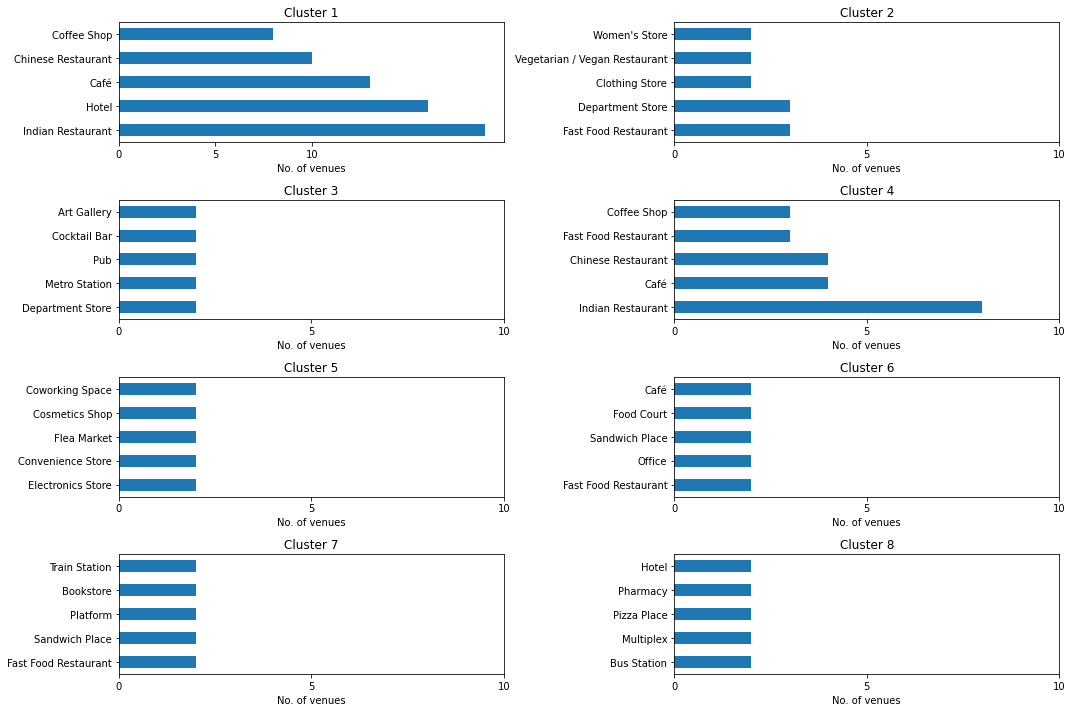

In [52]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1
        

fig.tight_layout()

These above  plots can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

## 5. Discussion <a name="Discussion"></a>

Let us discuss about appropriate business oportunity by Venue Category for certain targeted business set-ups.

#### A. Hotels

The neighborhoods in **cluster 1** has the greatest number of hotels,  Thus, an optimal place would be one which has less hotels, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 6 and Cluster 7 as it has some local cusine restaurant whihc would attract tourists who would love to experience these.

#### B. Multiplex

The neighborhoods in **cluster 2 and 5** has notable number of Multiplexes. By using the same procedure as above, the suitable cluster would be the Cluster 1 and since it has not much shopping malls and also it has many Hotels and Restaurants which gives an advantage.

Similarly, based on the requirement suggestions can be provided about the neighborhood that would be best suitable for the business.

#### C. Buisness Stores ***(Retail/Departmental/Wholesale)***

The neighborhoods in **cluster 3** has the greatest number of stores, Thus, an optimal place would be one which has less stores, but also have other attractions and other places to explore. Considering all these facts, the best choice would be Cluster 1 and Cluster 2 as it has some local cusine restaurant whihc would attract tourists who would love to experience these.

#### Map of Chennai with the clusters superimposed on top

This map can be used to find a suitable location to start a new business based on the Venue category.

I have added a most suitable location on CHENNAI map based on above analytics for a new business set-up

In [54]:
# getfolium
import folium 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install branca==0.3.1 

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
    
folium.CircleMarker([Blatitude, Blongitude],
                    radius=50,
                    popup='Chennai',
                    color='blue',
                    ).add_to(map_clusters)

# Interactive marker
map_clusters.add_child(folium.ClickForMarker(popup=popstring_new))
       
#map_clusters
map_clusters.save('map_clusters.html')


map_clusters

  Found existing installation: branca 0.4.2
    Uninstalling branca-0.4.2:
      Successfully uninstalled branca-0.4.2


This map can also be used to select a vast suggestion area for a particular type of business based on the category.

## 6. Conclusion <a name="Conclusion"></a>

Objective of this project was to analyze the neighborhoods of Chennai and create a clustering model to suggest potential places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build an appealing recommendation model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

